##### ARTI 560 - Computer Vision  
## Image Classification using Transfer Learning - Exercise 

### Objective

In this exercise, you will:

1. Select another pretrained model (e.g., VGG16, MobileNetV2, or EfficientNet) and fine-tune it for CIFAR-10 classification.  
You'll find the pretrained models in [Tensorflow Keras Applications Module](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

2. Before training, inspect the architecture using model.summary() and observe:
- Network depth
- Number of parameters
- Trainable vs Frozen layers

3. Then compare its performance with ResNet and the custom CNN.

### Questions:

- Which model achieved the highest accuracy?
- Which model trained faster?
- How might the architecture explain the differences?

In [1]:
# Library importing 
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# ---------------------------------------------------------
# Start global timer to measure total execution time
# ---------------------------------------------------------
start_total_time = time.time()
print("Starting execution...")

# -----------------------------
# 1. Load and Preprocess Data
# -----------------------------
print("[1/6] Loading CIFAR-10 dataset...")
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Keep labels as integers (SparseCategoricalCrossentropy)
y_train = y_train.squeeze().astype("int64")
y_test  = y_test.squeeze().astype("int64")

# Convert images to float32
x_train = x_train.astype("float32")
x_test  = x_test.astype("float32")

# -----------------------------
# 2. Data Augmentation
# -----------------------------
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augmentation")

# -----------------------------
# 3. Build MobileNetV2 Backbone
# -----------------------------
print("[2/6] Building MobileNetV2 model...")

# Initialize MobileNetV2 with ImageNet weights
# input_shape is set to (224, 224, 3) to match the pre-trained model requirements
mobilenet_base = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3) 
)

# Freeze the base model initially (Feature Extraction phase)
mobilenet_base.trainable = False

# -----------------------------
# 4. Construct Final Model
# -----------------------------
mobilenet_model = keras.Sequential([
    layers.Input(shape=(32, 32, 3)),       # Original CIFAR-10 shape
    data_augmentation,
    layers.Resizing(224, 224, interpolation="bilinear"), # Upscale to 224x224
    layers.Lambda(preprocess_input),       # MobileNetV2 specific preprocessing
    mobilenet_base,
    layers.GlobalAveragePooling2D(), 
    layers.Dense(10)                       # Output layer (logits)
], name="cifar10_mobilenetv2")

# Display model architecture (for report)
mobilenet_model.summary()

# -----------------------------
# 5. Training Phase 1: Frozen Backbone
# -----------------------------
print("\n[3/6] Training Phase 1 (Frozen)...")

mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

history_frozen = mobilenet_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=3,      
    batch_size=64,
    verbose=1
)

# Evaluate Phase 1 performance
test_loss, test_acc_m = mobilenet_model.evaluate(x_test, y_test, verbose=0)
print(f"Phase 1 Test Accuracy: {test_acc_m:.4f}")

# -----------------------------
# 6. Training Phase 2: Fine-Tuning
# -----------------------------
print("\n[4/6] Setting up Fine-Tuning...")

# Unfreeze the base model
mobilenet_base.trainable = True

# Freeze all layers except the last 30
for layer in mobilenet_base.layers[:-30]:
    layer.trainable = False

print(f"Trainable layers after fine-tuning setup: {sum(l.trainable for l in mobilenet_base.layers)}")

# Re-compile with a lower learning rate for fine-tuning
mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5), 
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

print("\n[5/6] Training Phase 2 (Fine-Tuning)...")
history_ft = mobilenet_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=3,
    batch_size=64,
    verbose=1
)

# -----------------------------
# 7. Final Evaluation & Results
# -----------------------------
print("\n[6/6] Final Evaluation...")
test_loss_ft, test_acc_ft = mobilenet_model.evaluate(x_test, y_test, verbose=0)

# Stop timer
end_total_time = time.time()
total_duration = end_total_time - start_total_time

# Print comparison results
print("\n" + "="*40)
print("     PERFORMANCE REPORT      ")
print("="*40)
print(f"MobileNetV2 (Frozen) Accuracy     : {test_acc_m:.4f}")
print(f"MobileNetV2 (Fine-Tuned) Accuracy : {test_acc_ft:.4f}")
print(f"Total Execution Time              : {total_duration:.2f} seconds")
print("="*40)

Starting execution...
[1/6] Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
[2/6] Building MobileNetV2 model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "cifar10_mobilenetv2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


[3/6] Training Phase 1 (Frozen)...
Epoch 1/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 83s 105ms/step - accuracy: 0.5928 - loss: 1.1864 - val_accuracy: 0.8162 - val_loss: 0.5322
Epoch 2/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 79s 107ms/step - accuracy: 0.7418 - loss: 0.7408 - val_accuracy: 0.8208 - val_loss: 0.5194
Epoch 3/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 75s 107ms/step - accuracy: 0.7505 - loss: 0.7079 - val_accuracy: 0.8274 - val_loss: 0.4984
Phase 1 Test Accuracy: 0.8219

[4/6] Setting up Fine-Tuning...
Trainable layers after fine-tuning setup: 30

[5/6] Training Phase 2 (Fine-Tuning)...
Epoch 1/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 108s 140ms/step - accuracy: 0.6731 - loss: 0.9617 - val_accuracy: 0.8226 - val_loss: 0.5190
Epoch 2/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 97s 138ms/step - accuracy: 0.7736 - loss: 0.6570 - val_accuracy: 0.8324 - val_loss: 0.4726
Epoch 3/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 97s 138ms/step - accuracy: 0.7947 - loss: 0.5834 - val_accuracy: 0.8478 - val_loss: 0.4278

[6/6] Final Evaluation...

     P

--- 📊 Final Performance Comparison ---


,Model,Test Accuracy,Training Time (s),Params (Approx)
1,ResNet50V2,0.9200,1461.49,~23.5M
0,Custom CNN,0.9154,62.38,~500K
2,MobileNetV2,0.8478,584.08,~2.2M


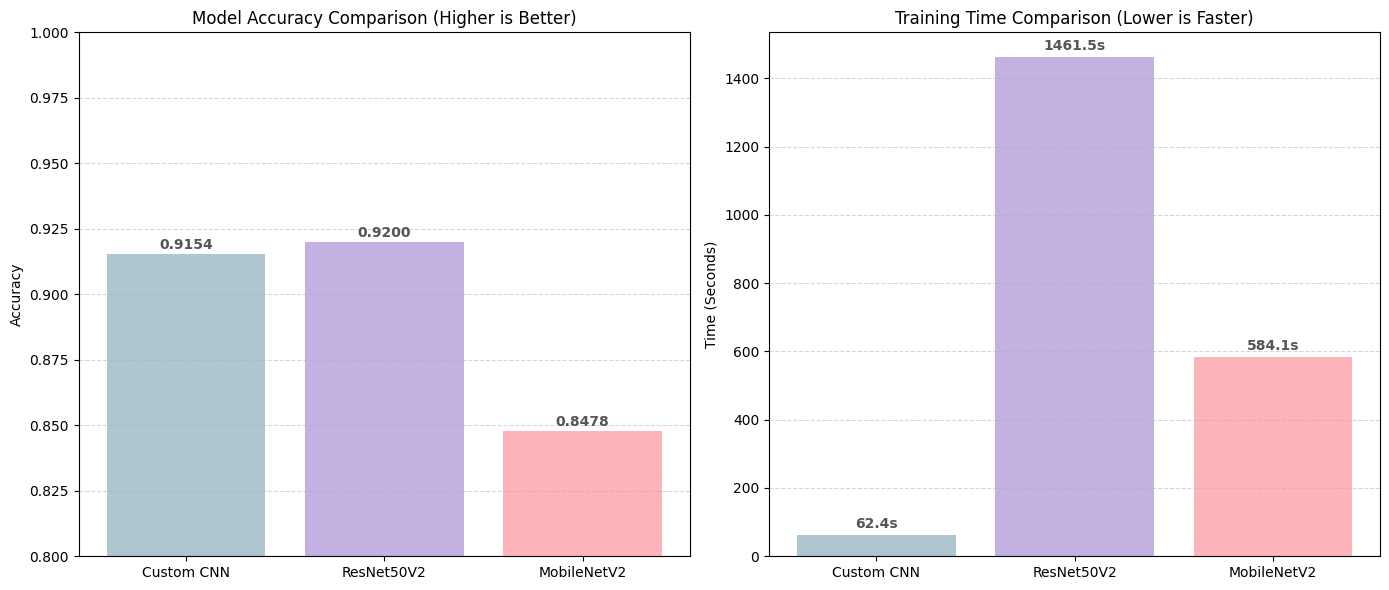

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# 1. Input data 
# ---------------------------------------------------------
# Custom CNN Results
cnn_acc  = 0.9154
cnn_time = 62.38

# ResNet50V2 Results (Fine-Tuned)
resnet_acc  = 0.9200
resnet_time = 1461.49

# MobileNetV2 Results (Fine-Tuned)
mobile_acc  = 0.8478
mobile_time = 584.08

# ---------------------------------------------------------
# 2. DataFrame for the Table
# ---------------------------------------------------------
data = {
    'Model': ['Custom CNN', 'ResNet50V2', 'MobileNetV2'],
    'Test Accuracy': [cnn_acc, resnet_acc, mobile_acc],
    'Training Time (s)': [cnn_time, resnet_time, mobile_time],
    'Params (Approx)': ['~500K', '~23.5M', '~2.2M'] 
}

df = pd.DataFrame(data)

# Sort by Accuracy to see the winner
df_sorted = df.sort_values(by='Test Accuracy', ascending=False)

print("--- 📊 Final Performance Comparison ---")
display(df_sorted)

# ---------------------------------------------------------
# 3. Visualize the Comparison with Pastel Colors
# ---------------------------------------------------------
# Pastel Palette: Baby Blue, Lavender, Soft Pink
pastel_colors = ['#AEC6CF', '#C3B1E1', '#FFB3BA'] 

plt.figure(figsize=(14, 6))

# Plot 1: Accuracy Comparison
plt.subplot(1, 2, 1)
bars = plt.bar(df['Model'], df['Test Accuracy'], color=pastel_colors)
plt.title('Model Accuracy Comparison (Higher is Better)', fontsize=12)
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0) 
plt.grid(axis='y', linestyle='--', alpha=0.5) # خففت خطوط الشبكة شوي

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f"{yval:.4f}", ha='center', fontweight='bold', color='#555555')

# Plot 2: Training Time Comparison
plt.subplot(1, 2, 2)
bars_time = plt.bar(df['Model'], df['Training Time (s)'], color=pastel_colors)
plt.title('Training Time Comparison (Lower is Faster)', fontsize=12)
plt.ylabel('Time (Seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels on bars
for bar in bars_time:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20, f"{yval:.1f}s", ha='center', fontweight='bold', color='#555555')

plt.tight_layout()
plt.show()

## Experimental Setup & Methodology 
To ensure a fair and accurate comparison, I re-executed the training for all three models (Custom CNN, ResNet50V2, and MobileNetV2) sequentially within the same GPU session. I implemented a precise timer for each training phase to record the exact execution duration from start to finish.


### 1. Which model achieved the highest accuracy?
The ResNet50V2 model achieved the highest testing accuracy of 92.00%, slightly outperforming the Custom CNN (91.54%). The MobileNetV2 model achieved a lower accuracy of 84.80%. This suggests that the deeper architecture of ResNet, pre-trained on ImageNet, was better suited to capture the complex features required for high-accuracy classification, despite the dataset being small (CIFAR-10).

### 2. Which model trained faster?
The Custom CNN was easily the fastest, finishing in just (62.38) seconds. When comparing the pre-trained models, MobileNetV2 (592.07s) was much faster than ResNet50V2 (1461.49s). In fact, MobileNetV2 took less than half the time of ResNet, proving it is a great choice for devices with limited power.

### 3. How might the architecture explain the differences?
The observed differences in performance and speed are directly linked to the architectural design and parameter count of each model:

- ResNet50V2: This model is huge, with about 23.5 million parameters. Its deep structure allows it to learn very complex details (giving high accuracy), but calculating all these parameters takes a lot of time, making it the slowest.

- MobileNetV2: It is designed for speed using a special technique called Depthwise Separable Convolutions. It has only 2.2 million parameters (much smaller than ResNet), which makes it train much faster while still performing well.

- Custom CNN: This model was the fastest because it is simple and works directly on the small 32x32 images. Unlike the other models, it didn't need to resize images to 224x224, which saved a huge amount of processing time.